# Brumm, Krause, Schaab, & Scheidegger (2021)

This file will not run in Jupyter. You have to run it in Julia. The goal of this file is pedagogical and it is meant to present the different steps of the implementatin of the IRBC model using sparse grid as proposed in Brumm et al. (Econometrica 2021).

In [63]:
import numpy as np
import Tasmanian
from scipy import optimize
import matplotlib.pyplot as plt
import argparse
import copy

# fixing the argparse issue in Jupyter
import sys

## Economic parameters

In [64]:
# Type of IRBC model ({'smooth','non-smooth'})
typeIRBC = 'non-smooth'
# Type of numerical integration: ({'GH-quadrature','monomials_2d','monomials_power'})
typeInt = 'monomials_power'

In [65]:
# Number of countries
nCountries = 2
# Number of shocks (Country-specific shocks + aggregate shock)
nShocks = nCountries+1
# Number of policies (nCountries+1 for smooth IRBC, nCountries*2+1 for nonsmooth)
if typeIRBC=='non-smooth':
    nPols = nCountries*2+1
elif typeIRBC=='smooth':
    nPols = nCountries+1
else:
    print('Error in determining the type of IRBC')
    exit()

In [66]:
# Intertemporal elasticity of substitution
a_eis = 0.25
b_eis = 1.0
gamma = np.zeros(nCountries)
for j1 in range(nCountries):
    gamma[j1] = a_eis+j1*(b_eis-a_eis)/(nCountries-1)
# Discount factor
betta = 0.99
# Capital share of income
zeta = 0.36
# Depreciation rate
delta = 0.01
# Persistence of TFP shocks
rhoZ = 0.95
# Standard deviation of TFP shocks
sigE = 0.01
# Intensity of capital adjustment costs
kappa = 0.5
# Steady state for capital
k_ss = 1.0
# Aggregate productivity
A_tfp = (1.0-betta*(1.0-delta))/(zeta*betta)
# Welfare weight
pareto = A_tfp**(1.0/gamma)

In [67]:
# Lower bound for capital
kMin = 0.8
# Upper bound for capital
kMax = 1.2
# Lower bound for TFP
aMin = -0.8*sigE/(1.0-rhoZ)
# Upper bound for TFP
aMax = 0.8*sigE/(1.0-rhoZ)

## Technical parameters

In [68]:
# Iteration to start at (start from scratch -- numstart =0; restart: numstart >0)
numstart = 0
# Maximum number of iterations
maxiter = 300
# Iteration at which the refinement starts
iterRefStart = 25
# Convergence criterion in time iteration
tol_ti = 1e-4
# Number of random draws for the error computation
TT = 10000
# Number of burn-in periods for SIMULATION
burnin = 1000
# Location where data is stored
data_location_nonsmooth = "data/data_nonsmooth/"
data_location_smooth = "data/data_smooth/"
# Frequency of saving grid
savefreq = 10

## Computing expectations : sets relevant parameters for the numerical integration and constructs nodes and weights 

In [69]:
if typeInt=='GH-quadrature':

    # Number of dimensions (One shock per country and the aggregate shock)
    int_dim = nCountries+1
    # Number of outputs
    int_out = 1
    # Level of integration grid (Number of points in each dimension; starts at 0)
    int_depth = 2
    # Tensor selection strategy
    int_type = "tensor"
    # Integration rule
    int_rule = "gauss-hermite"

    # Generate the grid structure
    int_grid = Tasmanian.makeGlobalGrid(int_dim, int_out, int_depth, int_type, int_rule)
    # Transform the nodes accordingly
    IntNodes = np.sqrt(2)*sigE*int_grid.getNeededPoints()
    # Get the corresponding quadrature weights
    IntWeights = int_grid.getQuadratureWeights()
    # Number of integration nodes
    numNodes = len(IntNodes)


elif typeInt=='monomials_2d':

    # Number of integration nodes
    numNodes = 2*nShocks
    # Pre-allocate nodes array
    z1 = np.zeros((numNodes,nShocks))
    # Fill nodes array with [1.0;-1.0]
    for i1 in range(nShocks):
        z1[i1*2,i1] = 1.0
        z1[i1*2+1,i1] = -1.0
    # Compute integration nodes
    IntNodes = z1*np.sqrt(nShocks)*sigE
    # Compute integration weights
    IntWeights = np.ones(numNodes)*1.0/numNodes


elif typeInt=='monomials_power':

    # Number of integration nodes
    numNodes = 2*nShocks**2 + 1

    z0 = np.zeros((numNodes,nShocks))

    # Deviations in one dimension (note that the origin is row zero)
    for i1 in range(nShocks):
        z0[i1*2+1,i1] = 1.0
        z0[i1*2+2,i1] = -1.0

    i0 = 0
    # Deviations in two dimensions
    for i1 in range(nShocks):
        for i2 in range(i1+1,nShocks):
            z0[2*nShocks+1+i0*4,i1] = 1.0
            z0[2*nShocks+2+i0*4,i1] = 1.0
            z0[2*nShocks+3+i0*4,i1] = -1.0
            z0[2*nShocks+4+i0*4,i1] = -1.0
            z0[2*nShocks+1+i0*4,i2] = 1.0
            z0[2*nShocks+2+i0*4,i2] = -1.0
            z0[2*nShocks+3+i0*4,i2] = 1.0
            z0[2*nShocks+4+i0*4,i2] = -1.0
            i0 += 1

    # Nodes
    IntNodes = np.zeros((numNodes,nShocks))
    IntNodes[1:nShocks*2+1,:] = z0[1:nShocks*2+1,:]*np.sqrt(2.0+nShocks)*sigE
    IntNodes[nShocks*2+1:] = z0[nShocks*2+1:]*np.sqrt((2.0+nShocks)/2.0)*sigE

    # Weights
    IntWeights = np.zeros(numNodes)

    IntWeights[0] = 2.0/(2.0+nShocks)
    IntWeights[1:nShocks*2+1] = (4-nShocks)/(2*(2+nShocks)**2)
    IntWeights[nShocks*2+1:] = 1.0/(nShocks+2)**2
    

else:

    print('Error in determining the type of numerical integration')
    exit()

## Auxiliary functions

### Production function : $y^j_t = a^j_t \cdot f^j(k^j_t)$

Functional form of the production function : $f^j (k^j_t) = A \cdot (k^j_t)^\zeta$

In [70]:
################################################################################
#                           Production function                                #
################################################################################

def F(capital,sh):

    FF = A_tfp * np.exp(sh)*np.maximum(capital,1e-6)**zeta

    return FF

### Law of motion of productivity : $\ln a^j_t = \rho \cdot \ln a^j_{t-1} + \sigma (e^j_t + e_t)$

### Marginal product of capital : ...

In [71]:
################################################################################
#                      Marginal product of capital                             #
################################################################################

def Fk(capital,sh):

    F_k =  A_tfp * zeta*np.exp(sh)*np.maximum(capital,1e-6)**(zeta-1.0)

    return F_k


### Convex adjustment cost on capital : $\Gamma^j_t ( k^j_t, k^j_{t+1} ) = \frac{\phi}{2} \cdot k^j_t \cdot \left( \frac{k^j_{t+1}}{k^j_t} - 1 \right)^2 $

In [72]:
################################################################################
#                          Capital adjustment cost                             #
################################################################################

def AdjCost(ktod,ktom):

    captod = np.maximum(ktod,1e-6)
    captom = np.maximum(ktom,1e-6)

    j = captom/captod - 1.0
    Adj_cost = 0.5 * kappa * j * j * captod

    return Adj_cost

### Derivative of capital adjustment cost w.r.t. _today_'s capital : ...

In [73]:
################################################################################
#        Derivative of capital adjustment cost w.r.t today's cap stock         #
################################################################################

def AdjCost_k(ktod,ktom):

    captod = np.maximum(ktod,1e-6)
    captom = np.maximum(ktom,1e-6)

    j = captom/captod - 1.0
    j1 = captom/captod + 1.0
    AdjCostk = (-0.5)*kappa*j*j1

    return AdjCostk

### Derivative of capital adjustment cost w.r.t. _tomorrow_'s capital : ...

In [74]:
################################################################################
#      Derivative of capital adjustment cost w.r.t tomorrows's cap stock       #
################################################################################

def AdjCost_ktom(ktod,ktom):

    captod = np.maximum(ktod,1e-6)
    captom = np.maximum(ktom,1e-6)

    j = captom/captod - 1.0
    AdjCostktom = kappa * j


    return AdjCostktom

### Residual of aggregate resource constraint (ARC) : ...

Aggregate resource constraint : $\sum^N_{j=1} \left( a^j_t \cdot f^j(k^j_t) + k^j_t \cdot (1-\delta) - k^j_{t+1} - \Gamma^j_t (k^j_t, k^j_{t+1}) - c^j_t \right) \geq 0 $

In [75]:
################################################################################
#                  Residual of aggregate resource constraint                   #
################################################################################
    
# This function is used to compute an initial guess for the ARC multiplier
# It computes the residual of the aggregate resource constraint given a
# guess for lambda and a grid point

def ARC_zero(lam_gues,gridPt):
    
    res = 0.0
    
    for i1 in range(nCountries):
        res += np.exp(gridPt[nCountries+i1])*A_tfp*gridPt[i1]**zeta - (-delta*kappa/2.0)**2 - (lam_gues/pareto[i1])**(-gamma[i1])
    
    return res

## Adaptative sparse grid : sets the relevant parameters for the adaptive sparse grid and initializes the grid structure that is used in the main file

In [76]:
################################################################################
#                               Grid construction                              #
################################################################################

# Number of dimensions (capital stock and tfp for each country)
gridDim = nCountries*2
# Number of outputs (capital policy & multiplier for each country + ARC multiplier)
gridOut = nPols
# Grid level (we start with a sparse grid of level 3)
gridDepth = 2
# 1=linear, 2=quadratic, 3=cubic
gridOrder = 1
# Type of base functions
gridRule = "localp"

# Set the grid domain to [kmin,kmax]^n x [amin,amax]^n
gridDomain = np.zeros((gridDim,2))

gridDomain[0:nCountries,0] = kMin
gridDomain[0:nCountries,1] = kMax
gridDomain[nCountries:,0] = aMin
gridDomain[nCountries:,1] = aMax

# Generate the grid structure
grid0 = Tasmanian.makeLocalPolynomialGrid(gridDim,gridOut,gridDepth,gridOrder,gridRule)
# Transform the domain
grid0.setDomainTransform(gridDomain)
# Get the points that require function values
aPoints = grid0.getPoints()
# Get the number of points that require function values
aNum = grid0.getNumPoints()

In [77]:
################################################################################
#                        Adaptivity parameters                                 #
################################################################################

# Surplus threshold
surplThreshold = 1e-3
# Number of maximum refinements
maxRef = 1
# Maximum Level of ASG
maxRefLevel = gridDepth + maxRef
# Outputs that are considered in the refinement process (-1 implies that all outputs are considered)
dimRef = -1
# Type of grid refinements
typeRefinement = 'classic'
# Scale correction in the refinement process:
# We only let the capital policies of each country determine the addition of grid points
scaleCorr = np.zeros(nPols)
scaleCorr[0:nCountries] = 1

In [78]:
################################################################################
#                             Initialization                                   #
################################################################################

# Our time iteration algorithm requires the initialization of policy functions,
# as these are necessary to interpolate for next period's policies. We make an
# educated guess here, assuming that capital choices are equal to the respective
# non-depreciated capital stock. This implies for the non-smooth model that the 
# irreversibility constraint is binding everywhere.

polGuess = np.zeros((aNum,nPols))

# Guesses for the capital policies and investment constraint multipliers:

for i0 in range(nCountries):
    polGuess[:,i0] = aPoints[:,i0]*(1.0-delta)

    if typeIRBC=='non-smooth':
        polGuess[:,nCountries+1+i0] = -delta*aPoints[:,i0]

# Guess for the aggregate ressource constraint multiplier:
#
# We use a nonlinear equation solver to find the ARC multipliers that are consistent
# with the guesses for the capital policies and investment constraint multipliers.

for i0 in range(aNum):
    root = optimize.root(ARC_zero, 0.1, method='lm', args=(aPoints[i0,:]))
    polGuess[i0,nCountries] = root.x
    # Print the status in case the solver did not find the root
    if root.success!= 1:
        print(root.message)


# Load function values into grid structure
grid0.loadNeededPoints(polGuess)

/tmp/ipykernel_28760/370763326.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  polGuess[i0,nCountries] = root.x


## Compute the expectations terms in the Euler equations of each country

In [79]:
def ExpectFOC(ktemp, state, grid):

    # 1) Determine next period's tfp states

    newstate = np.zeros((numNodes,nCountries))

    for itfp in range(nCountries):
        newstate[:,itfp] = rhoZ*state[nCountries+itfp] + (IntNodes[:,itfp] + IntNodes[:,nShocks-1])
        newstate[:,itfp] = np.where(newstate[:,itfp] > aMin, newstate[:,itfp], aMin)
        newstate[:,itfp] = np.where(newstate[:,itfp] < aMax, newstate[:,itfp], aMax)

    # 2) Determine next period's state variables

    evalPt = np.zeros((numNodes,nCountries*2))

    evalPt[:,0:nCountries] = ktemp
    evalPt[:,nCountries:] = newstate


    # 3) Determine relevant variables within the expectations operator

    capPrPr = grid.evaluateBatch(evalPt)[:,0:nCountries]
    lambPr = grid.evaluateBatch(evalPt)[:,nCountries]

    if typeIRBC=='non-smooth':
        gzAlphaPr = grid.evaluateBatch(evalPt)[:,nCountries+1:]
        gzAplusPr = np.maximum(0.0,gzAlphaPr)

    # Compute tomorrow's marginal productivity of capital
    MPKtom = np.zeros((numNodes,nCountries))
    for impk in range(nCountries):
        MPKtom[:,impk] = 1.0 - delta + Fk(ktemp[impk],newstate[:,impk]) - AdjCost_k(ktemp[impk],capPrPr[:,impk])


    #Compute Density
    if typeInt=='GH-quadrature':
        density = np.pi**(-(nCountries+1) * 0.5)
    else:
        density = 1.0

    #Specify Integrand
    ExpectFOC = np.zeros((numNodes,nCountries))

    if typeIRBC=='non-smooth':

        for iexp in range(nCountries):
            ExpectFOC[:,iexp] = (MPKtom[:,iexp]*lambPr - (1.0-delta)*gzAplusPr[:,iexp]) * density

    else:

        for iexp in range(nCountries):
            ExpectFOC[:,iexp] = MPKtom[:,iexp]*lambPr * density


    return ExpectFOC

## Computes the residuals of the system of equilibrium conditions

In [80]:
def sysOfEqs(x,state,grid):

    # State variables
    capStates = state[0:nCountries]
    tfpStates = state[nCountries:]

    # Policy values
    capPolicies = x[0:nCountries]
    lamb = x[nCountries]

    if typeIRBC=='non-smooth':

        gzAlphas = x[nCountries+1:]

        # Garcia-Zengwill transformation of the occasionally binding constraints
        gzAlphaPlus = np.maximum(0.0,gzAlphas)
        gzAlphaMinus = np.maximum(0.0,-gzAlphas)

    # Computation of integrands
    Integrands = ExpectFOC(capPolicies, state, grid)

    IntResult = np.empty(nCountries)

    for iint in range(nCountries):
        IntResult[iint] = np.dot(IntWeights,Integrands[:,iint])

    res = np.zeros(nPols)

    # Computation of residuals of the equilibrium system of equations

    if typeIRBC=='non-smooth':

        # Euler equations & GZ alphas
        for ires in range(nCountries):
            res[ires] = (betta*IntResult[ires] + gzAlphaPlus[ires])\
                            /(1.0 + AdjCost_ktom(capStates[ires],capPolicies[ires])) - lamb
            res[nCountries+1+ires] = capPolicies[ires] - capStates[ires]*(1.0-delta) - gzAlphaMinus[ires]

    else:

        # Euler equations
        for ires in range(nCountries):
            res[ires] = betta*IntResult[ires]/(1.0 + AdjCost_ktom(capStates[ires],capPolicies[ires])) - lamb


    # Aggregate resource constraint
    for ires2 in range(nCountries):
        res[nCountries] += F(capStates[ires2],tfpStates[ires2]) + (1.0-delta)*capStates[ires2] - capPolicies[ires2]\
                            - AdjCost(capStates[ires2],capPolicies[ires2]) - (lamb/pareto[ires2])**(-gamma[ires2])



    return res

## Time iteration procedure

In [81]:
################################################################################
#                           Time iteration step                                #
################################################################################

def ti_step(grid,pol_guess,gridZero):

    # Get the points that require function values
    aPoints1 = grid.getNeededPoints()
    # Get the number of points that require function values
    aNumAdd = grid.getNumNeeded()

    # Array for intermediate update step
    polInt = np.zeros((aNumAdd,nPols))

    # Time Iteration step
    for ii1 in range(aNumAdd):

        state = aPoints1[ii1]
        pol = pol_guess[ii1,:]
        root = optimize.root(sysOfEqs, pol, args=(state,gridZero), method='hybr')
        polInt[ii1,:] = root.x

    # Add the new function values to grid1
    grid.loadNeededPoints(polInt)


    return grid

In [82]:
################################################################################
#                             Grid refinement                                  #
################################################################################

def refine(grid):

    # Get the points that require function values
    aNumLoad = grid.getNumLoaded()
    # Scaling to only allow for those policies that are supposed to
    # determine the refinement process (in this case only the capital policies)
    scaleCorrMat = np.zeros((aNumLoad,nPols))
    scaleCorrMat[:,0:nPols+1] = scaleCorr

    # Refine the grid based on the surplus coefficients
    grid.setSurplusRefinement(surplThreshold, dimRef, typeRefinement, [], scaleCorrMat)

    if (grid.getNumNeeded()>0):

	    # Get the new points and the number of points
	    nwpts = grid.getNeededPoints()
	    aNumNew = grid.getNumNeeded()

	    # We assign (for now) function values through interpolation#
	    pol_guess = np.zeros((aNumNew,nPols))
	    pol_guess = grid.evaluateBatch(nwpts)

    else:

	    pol_guess = []


    return grid, pol_guess


In [83]:
################################################################################
#                        New grid construction                                 #
################################################################################

def fresh_grid():

    # Generate the grid structure
    grid = Tasmanian.makeLocalPolynomialGrid(gridDim,gridOut,gridDepth,gridOrder,gridRule)
    # Transform the domain
    grid.setDomainTransform(gridDomain)

    return grid

In [84]:
################################################################################
#                Checking convergence and updating policies                    #
################################################################################

def policy_update(gridOld,gridNew):

    # Get the points and the number of points from grid1
    aPoints2 = gridNew.getPoints()
    aNumTot = gridNew.getNumPoints()

    # Evaluate the grid points on both grid structures
    polGuessTr1 = gridNew.evaluateBatch(aPoints2)
    polGuessTr0 = gridOld.evaluateBatch(aPoints2)

    # 1) Compute the Sup-Norm

    metricAux = np.zeros(nPols)

    for imet in range(nPols):
        metricAux[imet] = np.amax(np.abs(polGuessTr0[:,imet]-polGuessTr1[:,imet]))

    metricSup = np.amax(metricAux)

    # 2) Compute the L2-Norm

    metricL2 = 0.0

    for imetL2 in range(nPols):
        metricL2 += np.sum((np.abs(polGuessTr0[:,imetL2]-polGuessTr1[:,imetL2]))**2)

    metricL2 = (metricL2/(aNumTot*nPols))**0.5

    metric = np.minimum(metricL2,metricSup)

    # Now update pol_guess and grid

    polGuess = np.zeros((aNumTot,nPols))

    for iupd in range(nPols):
        polGuess[:,iupd] = 0.5*polGuessTr0[:,iupd] + 0.5*polGuessTr1[:,iupd]

    gridOld = Tasmanian.copyGrid(gridNew)


    return metric, polGuess, gridOld

In [85]:
################################################################################
#                               Grid storage                                   #
################################################################################

def save_grid(grid,iter):

    if typeIRBC=='non-smooth':
        grid.write(data_location_nonsmooth + "grid_iter_" + str(iter+1) + ".txt")
    else:
        grid.write(data_location_smooth + "grid_iter_" + str(iter+1) + ".txt")


    return

## Postprocessing the model solution

In [86]:
################################################################################
#                   Errors along the simulation path                           #
################################################################################

def errors_sim(grid):

    # Set random seed and draw shocks
    np.random.seed(seed=24022021)
    shocks = np.random.normal(0,1,(TT+burnin,nCountries+1))

    # Preallocation of simulation arrays
    tfpSim = np.zeros((TT+burnin,nCountries))
    capSim = np.zeros((TT+burnin,nCountries))
    lMultSim = np.zeros(TT+burnin)

    if typeIRBC=='non-smooth':
        gzAlphaSim = np.zeros((TT+burnin,nCountries))

    errorEESim = np.zeros((TT+burnin,nCountries))
    if typeIRBC=='non-smooth':
        errorICSim = np.zeros((TT+burnin,nCountries))
    errorTotSim = np.zeros((TT+burnin,nCountries))

    # Initialization: Steady state values
    tfpSim[0,:] = 0.0
    capSim[0,:] = 1.0

    # Simulation loop
    for ia in range(TT+burnin-1):

        for icou in range(nCountries):
            tfpSim[ia+1,icou] = rhoZ*tfpSim[ia,icou] + sigE*(shocks[ia+1,icou]+shocks[ia+1,nCountries])

        stateSim = np.zeros(nCountries*2)
        stateSim[0:nCountries] = capSim[ia]
        stateSim[nCountries:] = tfpSim[ia+1]

        for icou in range(nCountries):
            capSim[ia+1,icou] = grid.evaluate(stateSim)[icou]
            if typeIRBC=='non-smooth':
                gzAlphaSim[ia+1,icou] = grid.evaluate(stateSim)[nCountries+1+icou]

        lMultSim[ia+1] = grid.evaluate(stateSim)[nCountries]

        policiesSim = np.zeros(nCountries*2+1)
        policiesSim[0:nCountries] = capSim[ia+1,:]
        policiesSim[nCountries] = lMultSim[ia+1]
        if typeIRBC=='non-smooth':
            policiesSim[nCountries+1:] = gzAlphaSim[ia+1,:]

        if typeIRBC=='non-smooth':
            for icou in range(nCountries):
                errorICSim[ia+1,icou] = 1.0 - capSim[ia+1,icou]/(capSim[ia,icou]*(1.0-delta))

        errorEESim[ia+1,:] = Euler_error(policiesSim,stateSim,grid)

        if typeIRBC=='non-smooth':
            for icou in range(nCountries):
                errorTotSim[ia+1,icou] = max(errorEESim[ia+1,icou],errorICSim[ia+1,icou],\
                                            np.minimum(-errorEESim[ia+1,icou],-errorICSim[ia+1,icou]))
        else:
            errorTotSim[ia+1,:] = errorEESim[ia+1,:]


    errorTotSim = errorTotSim[1000:,:]
    errorTotSimDist = np.sort(errorTotSim,axis=None)

    print('')
    print('Errors in Simulation:')
    print('Max error: ', np.log10(np.amax(np.abs(errorTotSimDist[:-100]))))
    print('Avg error: ', np.log10(np.mean(np.abs(errorTotSimDist[:]))))


    return

In [87]:
################################################################################
#                       Errors in the state space                              #
################################################################################

def errors_ss(grid):

    # Set random seed
    np.random.seed(seed=21042021)

    # Preallocation of simulation arrays
    tfpSS = np.zeros((TT,nCountries))
    capSS = np.zeros((TT,nCountries))

    kpSS = np.zeros((TT,nCountries))
    lMultSS = np.zeros(TT)
    if typeIRBC=='non-smooth':
        gzAlphaSS = np.zeros((TT,nCountries))

    errorEESS = np.zeros((TT,nCountries))
    if typeIRBC=='non-smooth':
	    errorICSS = np.zeros((TT,nCountries))
    errorTotSS = np.zeros((TT,nCountries))

    for i1 in range(TT):

        for icou in range(nCountries):
            tfpSS[i1,icou] = aMin + (aMax-aMin)*np.random.rand(1)

        for icou in range(nCountries):
            capSS[i1,icou] = kMin + (kMax-kMin)*np.random.rand(1)

        stateSS = np.zeros(nCountries*2)
        stateSS[0:nCountries] = capSS[i1,:]
        stateSS[nCountries:] = tfpSS[i1,:]

        for icou in range(nCountries):
            kpSS[i1,icou] = grid.evaluate(stateSS)[icou]
            if typeIRBC=='non-smooth':
                gzAlphaSS[i1,icou] = grid.evaluate(stateSS)[nCountries+1+icou]

        lMultSS[i1] = grid.evaluate(stateSS)[nCountries]

        policiesSS = np.zeros(nPols)
        policiesSS[0:nCountries] = kpSS[i1,:]
        policiesSS[nCountries] = lMultSS[i1]
        if typeIRBC=='non-smooth':
            policiesSS[nCountries+1:] = gzAlphaSS[i1,:]
        errorEESS[i1,:] = Euler_error(policiesSS,stateSS,grid)

        if typeIRBC=='non-smooth':
            for icou in range(nCountries):
                errorICSS[i1,icou] = 1.0 - kpSS[i1,icou]/(capSS[i1,icou]*(1.0-delta))
            for icou in range(nCountries):
                errorTotSS[i1,icou] = max(errorEESS[i1,icou],errorICSS[i1,icou],\
                                    np.minimum(-errorEESS[i1,icou],-errorICSS[i1,icou]))
        else:
            errorTotSS[i1,:] = errorEESS[i1,:]


    errorTotSSDist = np.sort(errorTotSS,axis=None)

    print('')
    print('Errors in State Space:')
    print('Max error: ', np.log10(np.amax(np.abs(errorTotSSDist[:-100]))))
    print('Avg error: ', np.log10(np.mean(np.abs(errorTotSSDist[:]))))

    return


In [88]:
################################################################################
#                       Euler equation errors                                  #
################################################################################

def Euler_error(x,state,pols):

    capStates = state[0:nCountries]
    tfpStates = state[nCountries:]

    capPolicies = x[0:nCountries]
    lamb = x[nCountries]

    Integrands = np.empty((numNodes,nCountries))
    newstate = np.empty(nCountries)
    captomtom = np.empty(nCountries)
    MPKtom = np.empty(nCountries)

    if typeIRBC=='non-smooth':

        gzAlpTomPl = np.empty(nCountries)

    #Compute Density
    if typeInt=='GH-quadrature':
        density = np.pi**(-(nCountries+1) * 0.5)
    else:
        density = 1.0

    for i_int in range(numNodes):

        for icou in range(nCountries):
            newstate[icou] = rhoZ*tfpStates[icou] + (IntNodes[i_int,icou] + IntNodes[i_int,nCountries])

        state_Sim = np.empty(nCountries*2)
        state_Sim[0:nCountries] = capPolicies
        state_Sim[nCountries:] = newstate

        lambtom = pols.evaluate(state_Sim)[nCountries]

        for icou in range(nCountries):
            captomtom[icou] = pols.evaluate(state_Sim)[icou]
            if typeIRBC=='non-smooth':
                gzAlpTomPl[icou] = np.maximum(0.0,pols.evaluate(state_Sim)[nCountries+1+icou])
            MPKtom[icou] = 1.0 - delta + Fk(capPolicies[icou],newstate[icou]) - AdjCost_k(capPolicies[icou],captomtom[icou])
            if typeIRBC=='non-smooth':
                Integrands[i_int,icou] = (lambtom*MPKtom[icou] - (1.0-delta)*gzAlpTomPl[icou]) * density
            else:
                Integrands[i_int,icou] = lambtom*MPKtom[icou] * density


    IntResult = np.empty(nCountries)

    for iint in range(nCountries):
        IntResult[iint] = np.dot(IntWeights,Integrands[:,iint])

    res = np.zeros(nCountries)

    for ires in range(nCountries):
        res[ires] = betta*IntResult[ires]/(lamb*(1.0 + AdjCost_ktom(capStates[ires],capPolicies[ires]))) - 1.0


    return res

In [89]:
################################################################################
#                   Plotting and storing policy functions                      #
################################################################################


def plot_policies(plotDim,grid):

    # Number of points in plot
    plotPoints = 50

    plotArray = np.linspace(gridDomain[plotDim,0],gridDomain[plotDim,1],plotPoints)


    # We fix every dimension at its steady state except plotDim
    steadyState = np.zeros(nCountries*2)
    steadyState[0:nCountries] = k_ss
    evalArray = steadyState*np.ones((plotPoints,nCountries*2))
    evalArray[:,plotDim] = plotArray

    policyArray = np.zeros((plotPoints,nCountries*2+1))
    # The first nCountries columns are grid points
    policyArray[:,:-1] = evalArray

    for iPlot in range(nPols):

        # The last column is the respective policy
        policyArray[:,-1] = grid.evaluateBatch(evalArray)[:,iPlot]

        if typeIRBC=='non-smooth':
            # Capital Policies
            if (iPlot<nCountries):
                np.savetxt(data_location_nonsmooth + "Cap_policy_" + str(iPlot) + ".txt", policyArray)

                fig,ax = plt.subplots(figsize=(16,8))
                ax.plot(plotArray,policyArray[:,-1])
                ## comment if error !
                #plt.savefig(data_location_nonsmooth + "Cap_policy_" + str(iPlot) + ".png", bbox_inches='tight')
                #plt.close()

            # ARC multiplier
            elif (iPlot==nCountries):
                np.savetxt(data_location_nonsmooth + "ARC_policy.txt", policyArray)

                fig,ax = plt.subplots(figsize=(16,8))
                ax.plot(plotArray,policyArray[:,-1])
                #plt.savefig(data_location_nonsmooth + "ARC_policy.png", bbox_inches='tight')
                #plt.close()

            # Investement constraint multipliers
            else:
                np.savetxt(data_location_nonsmooth + "IC_policy_" + str(iPlot-nCountries-1) + ".txt", policyArray)

                fig,ax = plt.subplots(figsize=(16,8))
                ax.plot(plotArray,policyArray[:,-1])
                #plt.savefig(data_location_nonsmooth + "IC_policy_" + str(iPlot-nCountries-1) + ".png", bbox_inches='tight')
                #plt.close()

        else:
            # Capital Policies
            if (iPlot<nCountries):
                np.savetxt(data_location_smooth + "Cap_policy_" + str(iPlot) + ".txt", policyArray)

                fig,ax = plt.subplots(figsize=(16,8))
                ax.plot(plotArray,policyArray[:,-1])
                #plt.savefig(data_location_smooth + "Cap_policy_" + str(iPlot) + ".png", bbox_inches='tight')
                #plt.close()

            # ARC multiplier
            else:
                np.savetxt(data_location_smooth + "ARC_policy.txt", policyArray)

                fig,ax = plt.subplots(figsize=(16,8))
                ax.plot(plotArray,policyArray[:,-1])
                #plt.savefig(data_location_smooth + "ARC_policy.png", bbox_inches='tight')
                #plt.close()

## Main code

In [90]:
# TeX Support for plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [91]:
# Parser settings for terminal calls
parser = argparse.ArgumentParser(description='Run the IRBC model.')
parser.add_argument('--final_grid', dest='load_flag', action='store_true', help='Postprocessing only')

# Parse with empty list or specific arguments
args = parser.parse_args([])  # For no arguments
# args = parser.parse_args(['--final_grid'])  # To enable the flag


In [92]:
#args = parser.parse_args()
load_flag = args.load_flag

In [93]:
# Replace with just the program name
sys.argv = [sys.argv[0]]

# Your parser code
parser = argparse.ArgumentParser(description='Run the IRBC model.')
parser.add_argument('--final_grid', dest='load_flag', action='store_true', help='Postprocessing only')

# Parse arguments
args = parser.parse_args()

# Now wrap your main code in a try-except to get better error information
try:
    # Your main code block here
    if args.load_flag:
        print('Postprocessing only.')
        # Construct the grid structure
        gridFinal = Tasmanian.TasmanianSparseGrid()
        # Read the properties from grid_final.txt
        gridFinal.read(data_location + "grid_final.txt")
        # Set as interpolation grid
        grid1 = Tasmanian.copyGrid(gridFinal)

    else:
    
        print('Start time iteration from iter = ', numstart)
    
        # If numstart==0 => start from scratch; numstart>0 => Restart from given iteration
    
        if (numstart>0):
    
            # Construct a new grid structure
            gridRestart = Tasmanian.TasmanianSparseGrid()
            # Read properties from file for restart
            gridRestart.read(data_location + "grid_iter_" + str(numstart) + ".txt")
            # Set as interpolation grid
            grid0 = Tasmanian.copyGrid(gridRestart)
    
        for iter0 in range(numstart,maxiter+1):
    
            polGuess1 = copy.copy(polGuess)
    
            grid1 = fresh_grid()
    
            # Index of current grid level to control the number of refinements
            ilev = gridDepth
    
            while ((grid1.getNumNeeded() > 0) and (ilev<=maxRefLevel)):
    
                grid1 = ti_step(grid1,polGuess1,grid0)
    
                # We start the refinement process after a given number of iterations
                if (iter0>iterRefStart):
                    grid1,polGuess1 = refine(grid1)
                    #grid1 = refine(grid1)
    
                # Track the grid level
                ilev += 1
    
            ## Calculate (approximate) errors on tomorrow's policy grid
            metric, polGuess, grid0 = policy_update(grid0,grid1)
    
            print("Iteration: %2d, Grid pts: %2d, Level: %2d, Metric: %.4E" % (iter0, grid0.getNumPoints(),ilev,metric))
    
            if (np.mod(iter0+1,savefreq)==0):
                save_grid(grid0,iter0)
    
            if (metric<tol_ti):
                break
    
        if typeIRBC=='non-smooth':
            grid1.write(data_location_nonsmooth + "grid_final.txt")
        else:
            grid1.write(data_location_smooth + "grid_final.txt")
    
        error_sim = errors_sim(grid1)
        errors_ss = errors_ss(grid1)

except Exception as e:
    print(f"Error occurred: {e}")
    import traceback
    traceback.print_exc()

Start time iteration from iter =  0
Iteration:  0, Grid pts: 41, Level:  3, Metric: 1.0330E-02
Iteration:  1, Grid pts: 41, Level:  3, Metric: 5.6600E-03
Iteration:  2, Grid pts: 41, Level:  3, Metric: 5.1416E-03
Iteration:  3, Grid pts: 41, Level:  3, Metric: 4.7272E-03
Iteration:  4, Grid pts: 41, Level:  3, Metric: 4.3946E-03
Iteration:  5, Grid pts: 41, Level:  3, Metric: 4.1431E-03
Iteration:  6, Grid pts: 41, Level:  3, Metric: 3.9024E-03
Iteration:  7, Grid pts: 41, Level:  3, Metric: 3.7053E-03
Iteration:  8, Grid pts: 41, Level:  3, Metric: 3.5381E-03
Iteration:  9, Grid pts: 41, Level:  3, Metric: 3.3935E-03
Iteration: 10, Grid pts: 41, Level:  3, Metric: 3.2624E-03
Iteration: 11, Grid pts: 41, Level:  3, Metric: 3.1523E-03
Iteration: 12, Grid pts: 41, Level:  3, Metric: 3.0554E-03
Iteration: 13, Grid pts: 41, Level:  3, Metric: 2.9669E-03
Iteration: 14, Grid pts: 41, Level:  3, Metric: 2.8894E-03
Iteration: 15, Grid pts: 41, Level:  3, Metric: 2.8222E-03
Iteration: 16, Grid 

/tmp/ipykernel_28760/2494503928.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tfpSS[i1,icou] = aMin + (aMax-aMin)*np.random.rand(1)
/tmp/ipykernel_28760/2494503928.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  capSS[i1,icou] = kMin + (kMax-kMin)*np.random.rand(1)



Errors in State Space:
Max error:  -2.1975691570396694
Avg error:  -3.0801915573634537


In [94]:
print(grid1)

In [95]:
# Get information about the grid
print(grid1.getNumDimensions())    # Number of dimensions
print(grid1.getNumPoints())        # Number of points in the grid
print(grid1.getNumLoaded())        # Number of loaded points
print(grid1.getNumNeeded())        # Number of needed points

# Get the actual grid points
points = grid1.getPoints()
print(points)

# Get grid weights if it's set up for quadrature
weights = grid1.getQuadratureWeights()
print(weights)

# Print a summary of the grid
print(grid1.printStats())

4
125
125
196
[[ 1.    1.    0.    0.  ]
 [ 1.    1.    0.   -0.16]
 [ 1.    1.    0.    0.16]
 [ 1.    1.    0.   -0.08]
 [ 1.    1.    0.    0.08]
 [ 1.    1.    0.   -0.12]
 [ 1.    1.    0.   -0.04]
 [ 1.    1.   -0.16  0.  ]
 [ 1.    1.   -0.16 -0.16]
 [ 1.    1.   -0.16  0.16]
 [ 1.    1.   -0.16 -0.08]
 [ 1.    1.   -0.16  0.08]
 [ 1.    1.    0.16  0.  ]
 [ 1.    1.    0.16 -0.16]
 [ 1.    1.    0.16  0.16]
 [ 1.    1.    0.16 -0.08]
 [ 1.    1.   -0.08  0.  ]
 [ 1.    1.   -0.08 -0.16]
 [ 1.    1.   -0.08  0.16]
 [ 1.    1.    0.08  0.  ]
 [ 1.    1.    0.08 -0.16]
 [ 1.    1.   -0.12  0.  ]
 [ 1.    1.   -0.04  0.  ]
 [ 1.    0.8   0.    0.  ]
 [ 1.    0.8   0.   -0.16]
 [ 1.    0.8   0.    0.16]
 [ 1.    0.8   0.   -0.08]
 [ 1.    0.8   0.    0.08]
 [ 1.    0.8  -0.16  0.  ]
 [ 1.    0.8  -0.16 -0.16]
 [ 1.    0.8  -0.16  0.16]
 [ 1.    0.8   0.16  0.  ]
 [ 1.    0.8   0.16 -0.16]
 [ 1.    0.8   0.16  0.16]
 [ 1.    0.8  -0.08  0.  ]
 [ 1.    0.8   0.08  0.  ]
 [ 1.    1.2  

Text(0, 0.5, 'Y')

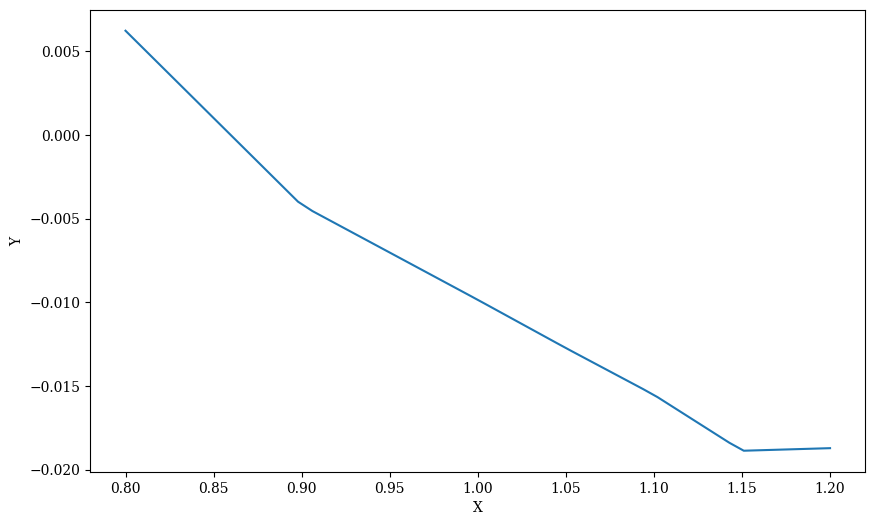

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Disable LaTeX rendering - add this before creating any plots
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'dejavusans'  # Use a standard font instead

# Read data from text file
data = np.loadtxt('data/data_nonsmooth/IC_policy_0.txt')  # Replace with your file path

# Basic plotting
plt.figure(figsize=(10, 6))


plt.plot(data[:, 1], data[:, 4])
plt.xlabel('X')
plt.ylabel('Y')

